# ML Lab: MLP in Metamaterial Inverse Design

This notebook is developed for the "Optimisation & Machine Learning" workshop, organised by UK Metamaterials Network (UKMMN); for educational purposes only.
- Authors: Erin Yu & Amber Wang (IDEA Lab, Imperial College London)
- Version: v1 (10/12/2025)
- Comments and corrections to a.panesar@imperial.ac.uk, erin.yu22@imperial.ac.uk, a.wang20@imperial.ac.uk

--------------

# (c). Extrapolation capability

### Content of ML Lab (c) tutorial

1. Split datasets for low and high metamaterial volume fraction 

2. Train MLP model with low volume fraction dataset

3. Test model performance on high volume fraction dataset

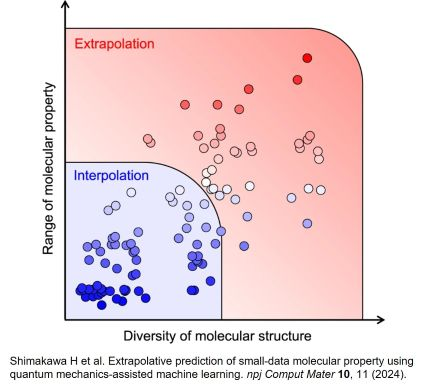

--------------

### Before you get started -  Import library

Run the cell below to import necessarry python libraries for this tutorial.

In [1]:
# --- Standard library
import time
import math
import random

# --- Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- PyTorch
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# --- Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load predefined functions
from homogenise2D import generate_BCC_unitcell
from MLPpackage import *
from MLPextention import *

-----------

### <span style="color:lightblue;">Load dataset </span>

In [2]:
# --- Load the dataset as numpy array
data  = np.load("dataset_2D_BCC_1000.npz")
prop  = data["prop"]    # input features
param = data["param"]   # target outputs

# --- Determine dimensions
N, in_dim  = prop.shape
_, out_dim = param.shape

### 1. Split dataset for conventional training and extrapolation test
Split dataset to main and extrapolation based on volume fraction of metamaterial unit cell. <br>
- Use main dataset for conventional training/validation/testing. <br>
- Then use extrapolation dataset to test extrapolation ability.

In [3]:
vol = prop[:, 6]  # Extract the volume fraction (7th column, index 6)
idx = np.argsort(vol); prop_s, param_s, vol_s = prop[idx], param[idx], vol[idx] # Sort samples by volume fraction
mid = len(vol_s) // 2 # Split by volume fraction into main half and extrapolation half
prop_main, prop_extrap  = prop_s[:mid],  prop_s[mid:]
param_main, param_extrap = param_s[:mid], param_s[mid:]

print(f"Main:          {prop_main.shape[0]} samples, vf ∈ [{vol_s[:mid].min():.3f}, {vol_s[:mid].max():.3f}]\n"
      f"Extrapolation: {prop_extrap.shape[0]} samples, vf ∈ [{vol_s[mid:].min():.3f}, {vol_s[mid:].max():.3f}]")

Main:          750 samples, vf ∈ [0.020, 0.277]
Extrapolation: 750 samples, vf ∈ [0.278, 0.628]


We visualise the sorted volume fractions as a scatter plot and draw a vertical dashed line at the split index, so you can clearly see how the dataset is divided into the “main” and “extrapolation” regions along volume fraction.

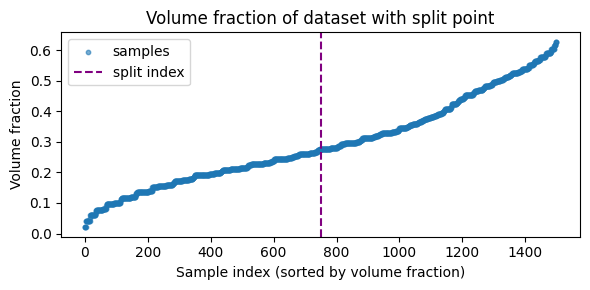

In [4]:
plot_vf_split(vol_s, mid)

### <span style="color:lightblue;">2. Preprocess the dataset and Train MLP model</span>

Preprocess the main dataset.

In [ ]:
# --- Split dataset
prop_train, prop_val, prop_test, param_train, param_val, param_test = split_prop_param(
    prop, param, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, print_summary=False)

In [ ]:
# --- Scale dataset
prop_train, prop_val, prop_test, param_train, param_val, param_test, in_scaler, out_scaler = scale_datasets(
    prop_train, prop_val, prop_test, param_train, param_val, param_test,
    scale_inputs=True, scale_outputs=True, feature_range=(-1, 1), print_summary=False)

In [ ]:
# --- Convert to Torch tensors
X_train, Y_train, X_val, Y_val, X_test, Y_test = map(
    lambda a: torch.from_numpy(a).float(),
    (prop_train, param_train, prop_val, param_val, prop_test, param_test))

In [ ]:
# --- Data loader
BATCH_SIZE = 256 # number of samples per mini-batch

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val,   Y_val),   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test,  Y_test),  batch_size=BATCH_SIZE, shuffle=False)

Conventional procedure for model training using main dataset.

In [ ]:
# --- Define model archietecture
HIDDEN = (8, )         # e.g., (), (64,), (128,64), (256,128,64), ...
DROPOUT = 0.0

model = MLP(in_dim=in_dim, hidden=HIDDEN, out_dim=out_dim, dropout=DROPOUT)

In [ ]:
# --- Train model
model, train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    epochs=300, # training epoch
    patience=20, # early stopping if no validation improvement
    criterion=nn.MSELoss(), # Mean Squared Error (MSE) loss for regression
    optimizer=torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4), # Adam optimizer – efficient and commonly used
)

=== Training started ===
Epoch   1/300 | Train: 0.287162 | Val: 0.293289
Epoch  20/300 | Train: 0.143904 | Val: 0.145472
Epoch  40/300 | Train: 0.060775 | Val: 0.060873
Epoch  60/300 | Train: 0.016635 | Val: 0.016414
Epoch  80/300 | Train: 0.005132 | Val: 0.005315
Epoch 100/300 | Train: 0.003586 | Val: 0.003817
Epoch 120/300 | Train: 0.003028 | Val: 0.003253
Epoch 140/300 | Train: 0.002709 | Val: 0.002870
Epoch 160/300 | Train: 0.002453 | Val: 0.002537
Epoch 180/300 | Train: 0.002261 | Val: 0.002318
Epoch 200/300 | Train: 0.002082 | Val: 0.002135
Epoch 220/300 | Train: 0.001885 | Val: 0.001925
Epoch 240/300 | Train: 0.001718 | Val: 0.001776
Epoch 260/300 | Train: 0.001575 | Val: 0.001592
Epoch 280/300 | Train: 0.001454 | Val: 0.001460
Epoch 300/300 | Train: 0.001336 | Val: 0.001333
=== Training complete ===


=== Test Metrics per Output ===
Output 0: MAE=0.003088, RMSE=0.003656, R^2=0.9951
Output 1: MAE=0.003181, RMSE=0.003988, R^2=0.9947
Output 2: MAE=0.003078, RMSE=0.003675, R^2=0.9951
Output 3: MAE=0.003193, RMSE=0.003936, R^2=0.9948

Overall MAE:  0.003135
Overall RMSE: 0.003814
Mean R^2:     0.9949


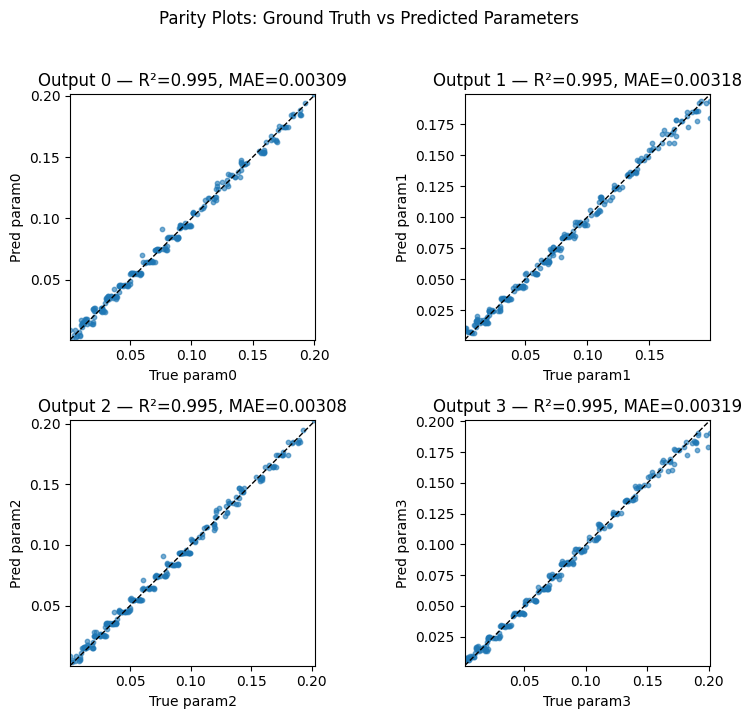

In [ ]:
# --- Evaluate model
y_true_plot, y_pred_plot, mae, rmse, r2 = evaluate_model(
    model, test_loader, out_dim=out_dim, out_scaler=out_scaler, scale_outputs=True, print_summary=True,)
plot_parity_plots(
    y_true_plot=y_true_plot, y_pred_plot=y_pred_plot, mae=mae, r2=r2, out_dim=out_dim,)

### 3. Test using extrapolation dataset

Use extrapolation dataset to see model's ability in extrapolation.
- First, preprocess the extrapolation dataset and prepare the dataloader.
- Then, use the Trained model to output metamaterial cell nodal parameters on extrapolation dataset.
- Finally, we compare the MLP’s outputs with the ground-truth values to see how well the model performs on samples outside the training range.
- This highlights a common limitation of standard MLPs: they often fit the training domain well but struggle to extrapolate reliably to unseen regions.

In [12]:
# ---- Preprocess extrapolation dataset
scale_inputs=True; scale_outputs=True # If you used Scaler on the main splits, apply the SAME scalers here.
prop_extrap_scaled  = in_scaler.transform(prop_extrap) if scale_inputs else prop_extrap
param_extrap_scaled = out_scaler.transform(param_extrap) if scale_outputs else param_extrap

X_extrap = torch.from_numpy(prop_extrap_scaled).float() # Convert to float32 tensors
Y_extrap = torch.from_numpy(param_extrap_scaled).float()
extrap_loader = DataLoader(TensorDataset(X_extrap, Y_extrap), batch_size=256, shuffle=False,)

In [13]:
# ---- Run the model on extrapolation dataset
y_true_ex_plot, y_pred_ex_plot, mae, rmse, r2 = evaluate_model(
    model, extrap_loader, out_dim=out_dim, out_scaler=out_scaler, scale_outputs=True, print_summary=True,)

=== Test Metrics per Output ===
Output 0: MAE=0.003035, RMSE=0.003618, R^2=0.9945
Output 1: MAE=0.003494, RMSE=0.004419, R^2=0.9917
Output 2: MAE=0.003105, RMSE=0.003686, R^2=0.9943
Output 3: MAE=0.003406, RMSE=0.004243, R^2=0.9923

Overall MAE:  0.003260
Overall RMSE: 0.003992
Mean R^2:     0.9932


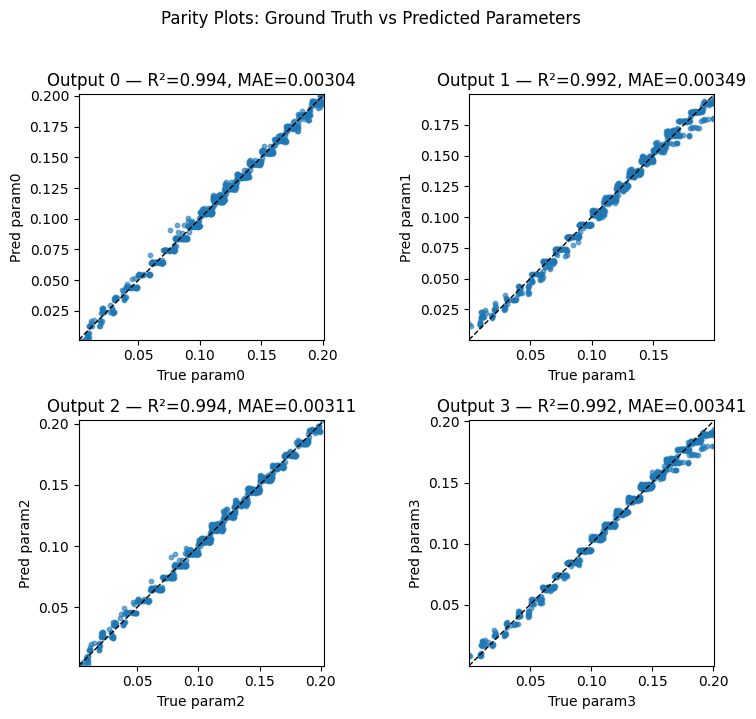

In [14]:
# ---- Compare model outputs with ground-truth values
plot_parity_plots(
    y_true_plot=y_true_ex_plot, y_pred_plot=y_pred_ex_plot, mae=mae, r2=r2, out_dim=out_dim,)